# Compute Antarctic, depth integrated, cross slope heat transport, online terms

We have

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=112)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 112
Total threads: 112,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41423,Workers: 112
Dashboard: /proxy/8787/status,Total threads: 112
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:42433,Total threads: 1
Dashboard: /proxy/46373/status,Memory: 2.23 GiB
Nanny: tcp://127.0.0.1:43113,


## Importing slope vars for transposition


In [3]:
Slopedata=xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/slope1000m.nc') #obtained through calc_u_on_depth_contour

## Getting the Heat Transport along isobath

In [4]:
session = cc.database.create_session()

In [5]:
year = '2080'
exp = '01deg_jra55v13_ryf9091'
#exp = '01deg_jra55v140_iaf'
#exp = '01deg_jra55v13_ryf9091_tides_fixed'

########################################################################################
#Setting the number of days in each month, so I can have the full date fo each month
#             J,  F,  M,  A,  M,  J,  J,  A,  S,  O,  N,  D]
monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
########################################################################################

start_time='2095-01'
end_time='2095-02'

#FOr importing the daily transports
start_time0='2095-01-01' 
end_time0='2095-01-' + str(monthdays[1-1])
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
#########################################################################################
# reference density value:
rho_0 = 1035.0
# specific heat capacity of sea water:
cp = 3992.1
lat_range = slice(-90,-59)

isobath_depth = 1000

# pick a freezing point temp:
temp_freezing = -3.82
end_time0

'2095-01-31'

## Open contour data, extract lat/lon on contour

In [6]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)

In [7]:
# convert isobath masks to data arrays, so we can multiply them later:
#mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")


mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")




# mask_x_transport = xr.DataArray(mask_x_transport, coords = [('yt_ocean', yt_ocean), ('xu_ocean', xu_ocean)])
# mask_y_transport = xr.DataArray(mask_y_transport, coords = [('yu_ocean', yu_ocean), ('xt_ocean', xt_ocean)])
# mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

In [8]:
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])   
    lon_along_contour[count-1] = xu_ocean[ii].values
    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
    count = int(count)
    jj = np.where(mask_y_transport_numbered==count)[0]
    ii = np.where(mask_y_transport_numbered==count)[1]
    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
    lat_along_contour[count-1] = yu_ocean[jj].values

In [9]:
Alat_along_contour=lat_along_contour
Alon_along_contour=lon_along_contour

In [10]:
lat_along_contournc=xr.DataArray(lat_along_contour)
lat_along_contournc.to_netcdf('/g/data/x77/wf4500/ASC_project/cross_slope_transport/lat_along_contour.nc')

## Compute heat transports calculated online

In [11]:
# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
# temp_yflux_adv = cp*rho*dzt*dxt*v*temp

temp_yflux = cc.querying.getvar(exp,'temp_yflux_adv',session,start_time=start_time, end_time=end_time)
temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time)

# select latitude range:
temp_yflux = temp_yflux.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)
temp_xflux = temp_xflux.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)

In [12]:
test = cc.querying.getvar(exp,'temp_yflux_adv',session,n=1)

In [13]:
# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
#temp_yflux_adv = cp*rho*dzt*dxt*v*temp

v = cc.querying.getvar(exp,'v',session,start_time=start_time, end_time=end_time,frequency='1 monthly')
u = cc.querying.getvar(exp,'u',session,start_time=start_time, end_time=end_time,frequency='1 monthly')

# select latitude range:
v = v.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)
u = u.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)

In [14]:
#Drawing the grid (example in the westernmost edge
                  
#
#   Legend:
#   o = u,v
#   x = tx, ty transport
#   t = Tracer grid (t,n)  
#
#
#
#         ty transport (-279.95,-81.09)
#           ^
#           | 
#   -------(+)------o=(u,v)(-279.90,-81.09)
#  |                |   
#  |                |
#  |                |
#  |       (t)     (+)--> Tx transport (-279.90,-81.11)
#  |                |
#  |                |
#  |                |
#   ----------------

In [15]:
# time average and sum in depth:
# temp_yflux = temp_yflux.mean('time').sum('st_ocean')
# temp_xflux = temp_xflux.mean('time').sum('st_ocean')
temp_yflux = temp_yflux.sum('st_ocean')
temp_xflux = temp_xflux.sum('st_ocean')

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

In [16]:
# temp_yflux_year = cc.querying.getvar(exp,'temp_yflux_adv',session,frequency='1 monthly').time
#temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time).sel(time=start_time)
#temp_yflux_year = temp_yflux_year.groupby('time.year').mean(dim='time')
#plt.plot(np.diff(temp_yflux_year.year)) #seems we have this variable every year, from 1950 to 2179
#so it shouldnt be a constraint
#temp_yflux_year.year

In [17]:
vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,frequency='1 daily')
#vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
#vhrho_nt
test = vhrho_nt.time.groupby('time.year').mean(dim='time')
#ok, it seems like the problem is that we dont have the  2080 year in some of the variables. We need to 
#choose a year of analysis where we have both vhrho_nt and and u,v for analysis, and temp_{x,y}flux

In [18]:
# save a long term average of vhrho_nt and uhrho_et:
outpath = '/g/data/x77/wf4500/ASC_project/uhrho_vhrho_'+start_time+'.nc'
# check if already exists:
if os.path.exists(outpath):
    average_transports = xr.open_dataset(outpath)
    # extract arrays from dataset:
    uhrho_et = average_transports.uhrho_et
    vhrho_nt = average_transports.vhrho_nt
else:
    vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,start_time=start_time0, end_time=end_time0,frequency='1 daily')
    uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,start_time=start_time0, end_time=end_time0,frequency='1 daily')
    #vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,frequency='1 daily')
    #uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,frequency='1 daily')



    vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
    uhrho_et = uhrho_et.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))

    vhrho_nt = vhrho_nt.mean('time')
    uhrho_et = uhrho_et.mean('time')
    
    
    # #outpath0= '/g/data/x77/wf4500/ASC_Project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/'
    # #os.mkdir('/g/data/x77/wf4500/ASC_Project/model_data/access-om2/')
    # #os.makedirs(outpath0)
    # outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
    # ds = xr.Dataset({'vhrho_nt': vhrho_nt,'uhrho_et':uhrho_et})
    # ds.to_netcdf(outpath)
    # ds.close()

In [19]:
#Importing data
import os
outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
ds = xr.open_dataset(outpath)
vhrho_nt = ds['vhrho_nt']
uhrho_et = ds['uhrho_et']

In [20]:
# subtract freezing point heat transport:
yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','yt_ocean',session,n=1)
dxu = cc.querying.getvar('01deg_jra55v13_ryf9091','dxu',session,n=1)
dyt = cc.querying.getvar(exp,'dyt',session,n=1)
# give dxu and dyt correct coordinates:
dxu.coords['nj'] = yt_ocean.values
dxu.coords['ni'] = xt_ocean['xt_ocean'].values
dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
dyt.coords['nj'] = yt_ocean.values
dyt.coords['ni'] = xt_ocean['xt_ocean'].values
dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
# select latitude range:
dxu = dxu.sel(yt_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)

In [21]:
# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
# but there is a problem with this diagnostic in older runs, and even
# using ty_trans, there is a slight difference. Not sure why?

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
# sum in depth:
vhrho_nt = vhrho_nt.sum('st_ocean')
uhrho_et = uhrho_et.sum('st_ocean')
# convert to transport:
vhrho_nt = vhrho_nt*dxu/rho_0
uhrho_et = uhrho_et*dyt/rho_0

In [22]:
# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
vhrho_nt.coords['yt_ocean'] = yu_ocean.values
vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
uhrho_et.coords['xt_ocean'] = xu_ocean.values
uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))

freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing

In [23]:
# compare both ways:
temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
temp_xflux = temp_xflux - freezing_point_heat_trans_zonal

In [24]:
#Importing  to transpose heat transport
slope = Slopedata.slope
dhu_dy = Slopedata.dhu_dy
dhu_dx = Slopedata.dhu_dx

Before transposing the heat flux, I need to put them into the same coordinate.

Coordinates guide: 

- temp_yflux(xt,yu)
- temp_xflux(xu,yt)
- slope(xu,yu)
- dhu_dy(xu,yu)
- dhu_dx(xu,yu)


In [25]:
temp_xfluxname = temp_xflux.rename('temp_xflux')
temp_yfluxname = temp_yflux.rename('temp_yflux')

In [26]:
#Interpolating the slope into the x and y grids
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([slope, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([slope, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
slope_xg=gridx.interp(dsx.slope, 'Y').isel(yt_ocean=slice(0,484))
slope_yg=gridx.interp(dsx.slope, 'X').isel(yu_ocean=slice(0,484))

In [27]:
#Interpolating the slope into the x and y grids
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([dhu_dy,dhu_dx, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([dhu_dy,dhu_dx, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
dhu_dy_xg=gridx.interp(dsx.dhu_dy, 'Y').isel(yt_ocean=slice(0,484))
dhu_dy_yg=gridx.interp(dsx.dhu_dy, 'X').isel(yu_ocean=slice(0,484))
dhu_dx_xg=gridx.interp(dsx.dhu_dx, 'Y').isel(yt_ocean=slice(0,484))
dhu_dx_yg=gridx.interp(dsx.dhu_dx, 'X').isel(yu_ocean=slice(0,484))

In [28]:
#Naming variables for wasier identification on which grid they are
temp_xflux_xg = temp_xfluxname
temp_yflux_yg = temp_yfluxname

In [29]:
#Finally we need to interpolate temp_xfluxname to the ygrid and temp_yfluxname to the xgrid


#Interpolating the slope into the x and y grids
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([temp_xfluxname, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([temp_yfluxname, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
    #Notice, that heat transport is calculated in TW=kg*m2*s. So it is a function of cross-section area.
    #The interpolation of the transport from the u corner grid into the x and y grid is simply linear
    #so it doesnt take into account that now we have 2 transports into the same cell. 
    #I will try to fix that by dividing the transport by 2 (not sure if it fixes the issue tho). Below are 2 tries
    
#Try 1, without dividing the transport by 2   
temp_xflux_yg=gridx.interp(dsx.temp_xflux, {'Y','X'}).isel(yu_ocean=slice(0,484))
temp_yflux_xg=gridy.interp(dsy.temp_yflux, {'Y','X'}).isel(yt_ocean=slice(0,484))


#Try 2, ividing the transport by 2   : I dint work
# temp_xflux_yg=gridx.interp(dsx.temp_xflux, {'Y','X'}).isel(yu_ocean=slice(0,484))/2
# temp_yflux_xg=gridy.interp(dsy.temp_yflux, {'Y','X'}).isel(yt_ocean=slice(0,484))/2

Now we (finally) have data in the x and y grids to calcualte the CSHT

In [30]:
#Ftemp_along on xgrid
Ftemp_along_xg = (temp_xflux_xg.isel(yt_ocean=slice(0,494)))*dhu_dy_xg/slope_xg \
- (temp_yflux_xg.isel(yt_ocean=slice(0,494)))*dhu_dx_xg/slope_xg
#Ftemp_along on ygrid
Ftemp_along_yg = (temp_xflux_yg.isel(yu_ocean=slice(0,494)))*dhu_dy_yg/slope_yg \
- (temp_yflux_yg.isel(yu_ocean=slice(0,494)))*dhu_dx_yg/slope_yg

#Ftemp_cross on xgrid
Ftemp_cross_xg  = (temp_xflux_xg.isel(yt_ocean=slice(0,494)))*dhu_dx_xg/slope_xg + \
(temp_yflux_xg.isel(yt_ocean=slice(0,494)))*dhu_dy_xg/slope_xg

#Ftemp_cross on ygrid
Ftemp_cross_yg  = (temp_xflux_yg.isel(yu_ocean=slice(0,494)))*dhu_dx_yg/slope_yg + \
(temp_yflux_yg.isel(yu_ocean=slice(0,494)))*dhu_dy_yg/slope_yg



In [31]:
#For the case of (i,j) space
temp_yflux_with_mask = np.multiply(np.array(temp_yflux),np.array(mask_y_transport))
temp_xflux_with_mask = np.multiply(np.array(temp_xflux),np.array(mask_x_transport))

temp_yflux_with_mask = temp_yflux_with_mask[0]
temp_xflux_with_mask =temp_xflux_with_mask[0]


Now we need to extract the contour

In [32]:
mask_x= np.abs(mask_x_transport.rename(xu_ocean='x_ocean',yt_ocean='y_ocean')).isel(y_ocean=slice(0,484))
mask_y= np.abs(mask_y_transport.rename(xt_ocean='x_ocean',yu_ocean='y_ocean')).isel(y_ocean=slice(0,484))


mask_x=np.where(mask_x==0,0,1,)
mask_x = np.ma.masked_where(mask_x==0, mask_x, copy=True)
mask_y=np.where(mask_y==0,0,1,)
mask_y = np.ma.masked_where(mask_y==0, mask_y, copy=True)

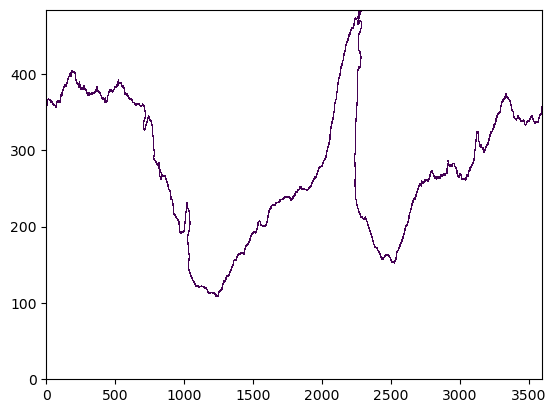

In [33]:
#mask for both x and y
mask= (np.array(np.abs(mask_x_transport).isel(yt_ocean=slice(0,484))) + np.array(np.abs(mask_y_transport).isel(yu_ocean=slice(0,484))))/2
mask=np.where(mask==0,0,1,)
#mask = np.ma.masked_array(mask, mask=[0, 0, 0, 1, 0])
mask = np.ma.masked_where(mask==0, mask, copy=True)
mask
plt.pcolor(mask)

In [34]:
Ftemp_cross_xg2=Ftemp_cross_xg.isel(time=0)#*mask_x
Ftemp_cross_yg2=Ftemp_cross_yg.isel(time=0)#*mask_y
Ftemp_along_xg2=Ftemp_along_xg.isel(time=0)#*mask_x
Ftemp_along_yg2=Ftemp_along_yg.isel(time=0)#*mask_y



In [35]:
Fx_yocean=Ftemp_cross_xg2.yt_ocean
Fx_xocean=Ftemp_cross_xg2.xu_ocean

Fy_yocean=Ftemp_cross_yg2.yu_ocean
Fy_xocean=Ftemp_cross_yg2.xt_ocean




In [36]:
from joblib import Parallel, delayed
def HT_paralel(yu_ocean,yt_ocean,xu_ocean,xt_ocean,Alat_along_contour,Alon_along_contour,Ftemp_cross_xg2,Ftemp_cross_yg2, n):  
    #Ftemp_cross_contour_xyg = np.zeros(1)
    # Ftemp_cross_contour_yg = np.zeros(1)
    
    try:
        Ftemp_cross_contour_xyg=Ftemp_cross_xg2.sel(yt_ocean=Alat_along_contour[n],xu_ocean=Alon_along_contour[n])
    except:
        print('Value not on xgrid')
        try:
            Ftemp_cross_contour_xyg=Ftemp_cross_yg2.sel(yu_ocean=Alat_along_contour[n],xt_ocean=Alon_along_contour[n])
        except:
            print('Value not on ygrid either for n='+str(n))   
            Ftemp_cross_contour_xyg=0
    vary_full=np.array(Ftemp_cross_contour_xyg)

    
    return vary_full #[Ftemp_cross_contour_xg,Ftemp_cross_contour_yg] 



In [37]:
# %%time
# results = Parallel(n_jobs=-1)(delayed(HT_paralel)(yu_ocean,yt_ocean,xu_ocean,xt_ocean,Alat_along_contour,Alon_along_contour,Ftemp_cross_xg2,Ftemp_cross_yg2, n) for n in range(10))




In [39]:
%%time
results = Parallel(n_jobs=-1)(delayed(HT_paralel)(yu_ocean,yt_ocean,xu_ocean,xt_ocean,Alat_along_contour,Alon_along_contour,Ftemp_cross_xg2,Ftemp_cross_yg2, n) for n in range(num_points))




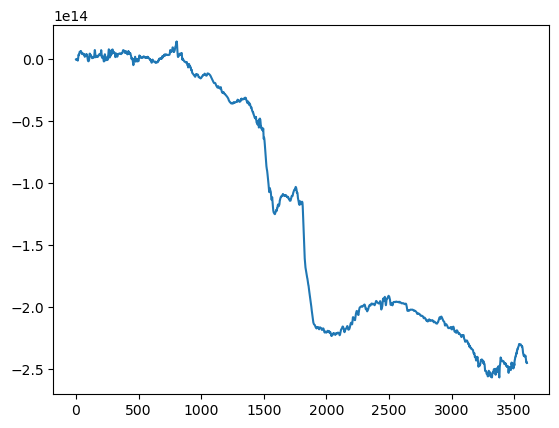

In [40]:
plt.plot(np.cumsum(results))

In [41]:
Ftemp_cross_contour_xyg=results

In [42]:
src = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_2095-01.nc'
HTz = xr.open_dataset(src)
#Dcross_slope_heat_trans= (HTz.cross_slope_heat_trans*factor) + (HTz.zonal_convergence*factor)
Ocross_slope_heat_trans= (HTz.cross_slope_heat_trans)
Oheat_trans_across_contour= (HTz.heat_trans_across_contour)
Ozonal_convergence = (HTz.zonal_convergence)

factor = np.nansum(HTz.heat_trans_across_contour)/np.nansum(HTz.cross_slope_heat_trans+HTz.zonal_convergence)

The total values below get quite different (total HC(a,c)) is much bigger. A possible reason for this is that Adele's point selection for isobaths use both the x and y grid. Whle the Fcross is always on the Tgrid. How do we fix that?

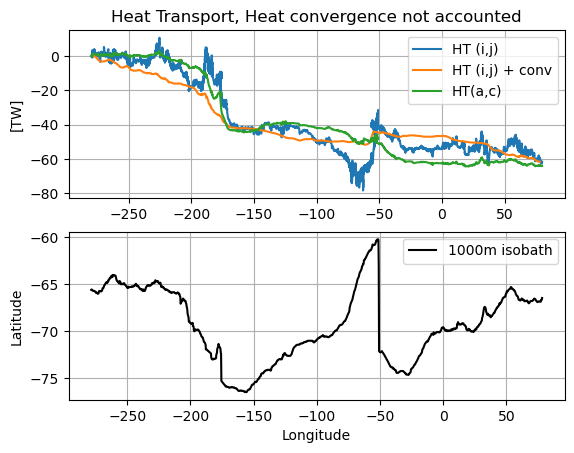

Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on xgrid
Value not on

In [43]:
plt.subplot(2,1,1)
plt.plot(HTz.lon_along_contour,np.cumsum(Oheat_trans_across_contour)/1e12,label='HT (i,j)')
plt.plot(HTz.lon_bin_midpoints,np.cumsum((HTz.cross_slope_heat_trans + HTz.zonal_convergence)*factor)/1e12,label='HT (i,j) + conv')
plt.plot(Alon_along_contour,np.cumsum(np.nan_to_num(Ftemp_cross_contour_xyg))/5e12,label='HT(a,c)')
plt.title("Heat Transport, Heat convergence not accounted")
plt.ylabel('[TW]')

# plt.xlim(-280,-200)
# plt.ylim(-40,20)
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,color='black',label='1000m isobath')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()